In [31]:
from snake_v0_ai import Game, RenderMode

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import pickle
import random
from collections import deque
from IPython.display import clear_output

In [32]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 1e-2
GAMMA = 0.9

GAME_FIELD_SIZE = 14

STATE_VECTOR_SIZE = 11
WEIGHTS_DIRECTORY = "value_based/q/binary"

In [33]:
class Linear(tf.Module):

    def __init__(self, in_size: int, out_size: int):
        super().__init__()
        w = tf.random.normal((in_size, out_size))
        b = tf.random.normal((out_size, ))
        self.w = tf.Variable(w)
        self.b = tf.Variable(b)

    def __call__(self, x):
        return x@self.w + self.b

In [34]:
class Model(tf.Module):

    def __init__(self, in_size: int, out_size: int, name: str):
        super().__init__(name=name)
        self.linear1 = Linear(in_size, 256)
        self.linear2 = Linear(256, out_size)

    def __call__(self, x) -> tf.Tensor:
        x = self.linear1(x)
        x = tf.nn.relu(x)
        x = self.linear2(x)
        x = tf.nn.softmax(x)
        return x
    
    def save_weights(self, dir: str, prefix: str = "", postfix: str = ""):
        with open(f"{dir}/{prefix}{self.name}{postfix}.weights", "wb") as file:
            pickle.dump(self.trainable_variables, file)

    def load_weights(self, path: str):
        with open(path, "rb") as file:
            weights = pickle.load(file)

        for src, dest in zip(weights, self.trainable_variables):
            dest.assign(src.numpy())            

In [35]:
class Trainer:

    def __init__(self, model: Model, lr, gamma) -> None:
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = tf.optimizers.Adam(lr)

    def train_step(self, states, actions, rewards, next_states, dones):
        with tf.GradientTape() as tape:
            pred = self.model(states)
            target = pred.numpy()        

            for i, done in enumerate(dones):
                q_new = rewards[i]
                if not done:
                    q_new = rewards[i] + self.gamma * np.max(self.model(next_states[i][None, ...]).numpy())
                    target[i][int(actions[i]) + 1] = q_new

            loss = self.loss_func(target, pred)
        
        weights = self.model.trainable_variables
        grads = tape.gradient(loss, (weights,))
        self.optimizer.apply_gradients(zip(grads[0], weights))


    def loss_func(self, true, pred):
        return tf.reduce_mean(tf.losses.mse(true, pred))

In [36]:
class Agent:

    def __init__(self, model: Model, trainer: Trainer):
        self.n_games = 0
        self.epsilon = 0
        self.gamma = 0
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = model
        self.trainer = trainer
        self.stats = {
            "scores": [],
            "rewards": [],
        }

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_short_memory(self, *params):
        # def train_short_memory(self, state, action, reward, next_state, done):
        # self.trainer.train_step(
        #     tf.convert_to_tensor([state]),
        #     tf.convert_to_tensor([action]),
        #     tf.convert_to_tensor([reward]),
        #     tf.convert_to_tensor([next_state]),
        #     tf.convert_to_tensor([done]),
        # )
        self.trainer.train_step(*[tf.convert_to_tensor([param], dtype="float32") for param in params])

    def train_long_memory(self):        
        batch = random.sample(self.memory, BATCH_SIZE) \
            if len(self.memory) > BATCH_SIZE \
            else self.memory
        
        params = [tf.convert_to_tensor(param, dtype="float32") for param in  zip(*batch)]
        
        self.trainer.train_step(*params)
                    
    def generate_action(self, state):
        self.epsilon = 100 - self.n_games

        if random.randint(0, 200) < self.epsilon:
            action = random.choice([-1, 0, 1])

        else:
            action = self.model(state[None, ...]).numpy()
            action = np.argmax(action) - 1
        
        return action
    
    def plot_statistics(self):
        fig, (lax, rax) = plt.subplots(1, 2, figsize=(15, 5))
        lax.plot(self.stats["scores"])
        lax.set_title(f"Scores")
        rax.plot(self.stats["rewards"])
        rax.set_title(f"Rewards")
        fig.suptitle(f"{self.n_games} games")
        plt.show()

    def backup(self):
        self.model.save_weights(WEIGHTS_DIRECTORY, prefix="tf_", postfix=f"_{self.n_games}")


In [45]:
model = Model(STATE_VECTOR_SIZE, 3, name="model1")

In [47]:
model.load_weights("weights/q/tf_model1_1.weights")

In [39]:
trainer = Trainer(model, LR, GAMMA)
agent = Agent(model, trainer)

In [40]:
env = Game(GAME_FIELD_SIZE, mode=RenderMode.BINARY_VECTOR, verbose=True)

In [41]:
def start_epoch(agent: Agent):
    
    old_state, info = env.reset()
    steps_without_apple = 0
    total_reward = 0
    
    done = False
    while not done:
        steps_without_apple += 1
        action = agent.generate_action(old_state)
        new_state, reward, done, _ = env.step(action)

        if reward == 100:
            steps_without_apple = 0

        if steps_without_apple > env.setup.FIELD_SIZE**2 * 1.4:
            reward = -100
            break
        
        agent.train_short_memory(old_state, action, reward, new_state, done)
        agent.remember(old_state, action, reward, new_state, done)
        old_state = new_state

        total_reward += reward

    return env.score - 3, total_reward

In [42]:
def train(agent: Agent, epochs: int, display_frequency: int = 100):
    
    for i in range(epochs):
        score, reward = start_epoch(agent)
        agent.n_games += 1
        agent.stats["scores"].append(score)
        agent.stats["rewards"].append(reward)
        agent.train_long_memory()
        clear_output(True)
        print(f"Epoch {i + 1}", end="\r")
        agent.plot_statistics()

        if (i + 1) % display_frequency == 0:
            agent.backup()

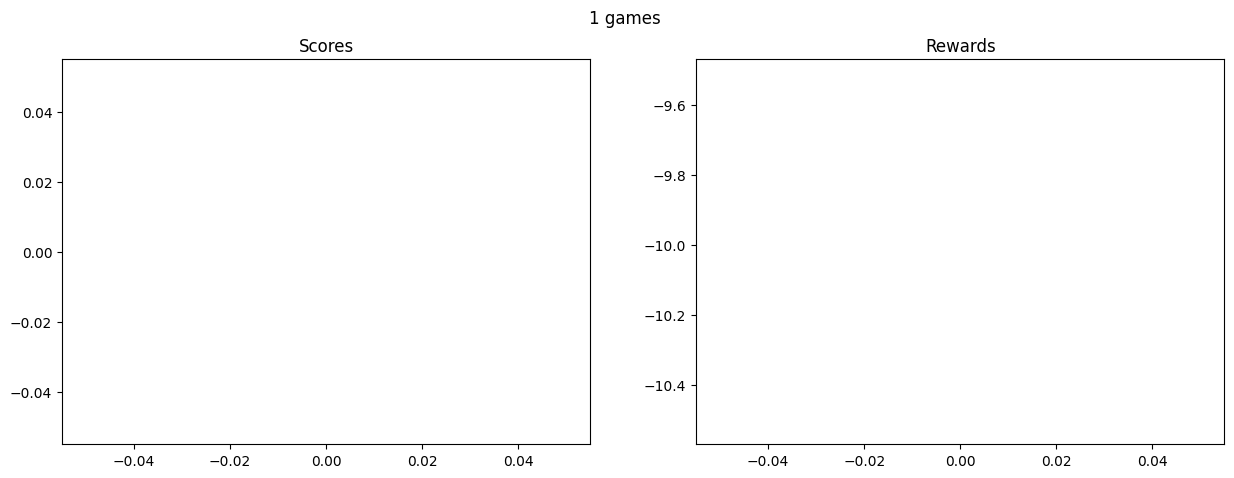

In [43]:
train(agent, 1, 1)